<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/khf7_Vasarely.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/vasarely.bmp

--2024-12-06 21:12:01--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/vasarely.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3055670 (2.9M) [image/bmp]
Saving to: ‘vasarely.bmp.3’

vasarely.bmp.3      100%[===================>]   2.91M  --.-KB/s    in 0.08s   

2024-12-06 21:12:01 (36.7 MB/s) - ‘vasarely.bmp.3’ saved [3055670/3055670]



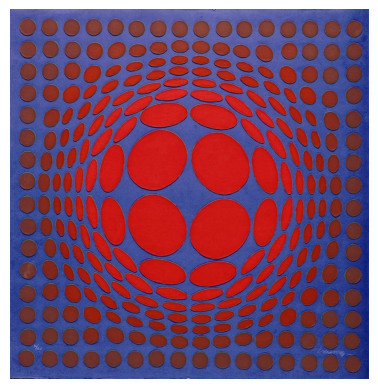

In [3]:
# Kép betöltése
img = cv2.imread('vasarely.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img)

## BLOB-ok szín szerinti szegmentálása

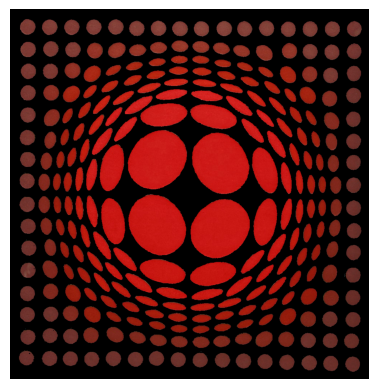

In [4]:
# Forrás: https://ujangriswanto08.medium.com/a-beginners-guide-to-image-segmentation-using-color-masking-3a3fd536ed25

# Áttérés HSV színtérre
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Maszk definiálása
lower_red = np.array([0, 80, 80]) # Hue, Saturation, Value
upper_red = np.array([100, 255, 255])
red_mask = cv2.inRange(img_hsv, lower_red, upper_red)

# Maszk alkalmazása a képre
img_segmented = cv2.bitwise_and(img, img, mask=red_mask)

plt.axis("off")
plt.imshow(img_segmented)

## BLOB-ok detektálása

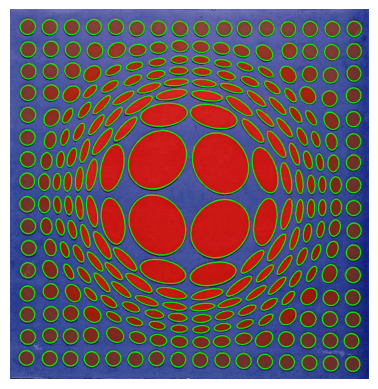

In [5]:
# Maszk binarizálása a biztonság kedvéért
_, red_mask_binary = cv2.threshold(red_mask, 127, 255, cv2.THRESH_BINARY)

# Ellipszis kontúrok és főtengelyek megkeresése
contours, _ = cv2.findContours(red_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ellipszisek vizualizálandó adatainak eltárolása
center_xs = []
center_ys = []
major_axis_lengths = []

img_with_contours = img.copy()

# Vizualizálandó adatok kigyűjtése
for contour in contours:
  if len(contour) >= 10: # Ennyi találat kell, hogy valamit ellipszisnek számítsunk
      ellipse = cv2.fitEllipse(contour)
      center, axes, _ = ellipse
      major_axis_length = max(axes)
      center_xs.append(center[0])
      center_ys.append(center[1])
      major_axis_lengths.append(major_axis_length)

      # Ellipszisek képre kajzolása
      cv2.ellipse(img_with_contours, ellipse, (0, 255, 0), 2)

plt.axis("off")
plt.imshow(img_with_contours)

## 3D modell elkészítése

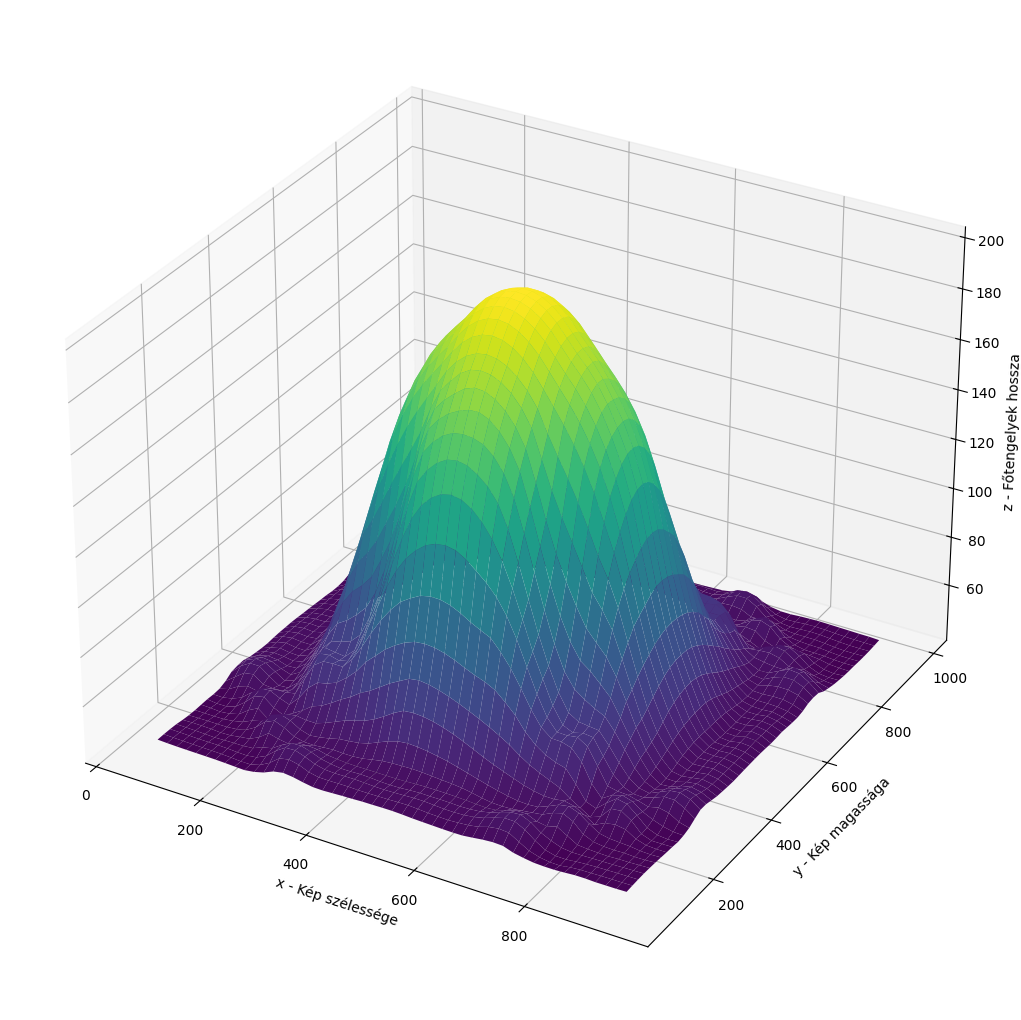

In [6]:
from scipy.interpolate import griddata # Az interpolációhoz (ugyan nem volt kötelező, de ChatGPT segítséggel megcsináltam)

# meshgrid definiálása
grid_x, grid_y = np.meshgrid(
    np.linspace(np.min(center_xs), np.max(center_xs)),
    np.linspace(np.min(center_ys), np.max(center_ys))
)

# major_axis_lengths rárakása a grid-re + interpoláció
grid_z = griddata((center_xs, center_ys), major_axis_lengths, (grid_x, grid_y), method='cubic')

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

# Felület megadása
surface = ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none')

ax.set_xlabel("x - Kép szélessége")
ax.set_ylabel("y - Kép magassága")
ax.set_zlabel("z - Főtengelyek hossza")
plt.show()